# Learning aggregate functions #



In [1]:
import numpy as np 
import pandas as pd 
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

In [2]:
import random
seed = 1387
random.seed(seed)
np.random.seed(seed)

## 1. Loading the data ##

First, we load the `new_merchant_transactions.csv` and `historical_transactions.csv`. In practice, these two files contain the same variables and the difference between the two tables only concern the position with respect to a reference date.  Also, booleans features are made numeric:

In [3]:
#new_transactions = pd.read_csv('../input/new_merchant_transactions.csv', parse_dates=['purchase_date'])
historical_transactions = pd.read_csv('../input/historical_transactions.csv', parse_dates=['purchase_date'])
#all_transactions = pd.concat([historical_transactions,new_transactions])
all_transactions = historical_transactions.sample(frac=0.1, random_state=seed)
all_transactions.head(2)

,authorized_flag,card_id,city_id,category_1,installments,category_3,merchant_category_id,merchant_id,month_lag,purchase_amount,purchase_date,category_2,state_id,subsector_id
22775109,N,C_ID_473b843c9d,333,N,0,A,437,M_ID_c0deafd324,-3,-0.713729,2017-08-21 15:38:00,1.0,9,15
10227162,Y,C_ID_71cb477648,304,N,0,A,80,M_ID_e6bc585098,-1,-0.736765,2018-01-19 21:52:31,5.0,20,37


C:\Anaconda\lib\site-packages\matplotlib\axes\_axes.py:6462: UserWarning: The 'normed' kwarg is deprecated, and has been replaced by the 'density' kwarg.
  warnings.warn("The 'normed' kwarg is deprecated, and has been "


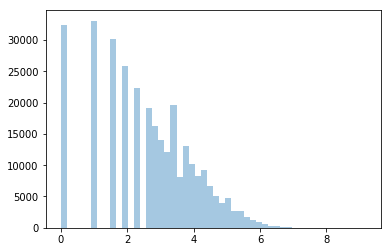

In [4]:
sns.distplot(np.log2(all_transactions.groupby('card_id').agg({'card_id': 'count'}).values), kde=False);

In [5]:
all_transactions.authorized_flag = all_transactions.authorized_flag == 'Y'
all_transactions.category_1 = all_transactions.category_1 == 'Y'
dummied = all_transactions
dummied = pd.get_dummies(dummied, dummy_na=True, drop_first=True, columns=['category_2'])
dummied = pd.get_dummies(dummied, dummy_na=True, drop_first=True, columns=['category_3'])
dummied = pd.get_dummies(dummied, dummy_na=True, drop_first=True, columns=['city_id'])
dummied = pd.get_dummies(dummied, dummy_na=True, drop_first=True, columns=['state_id'])
dummied = pd.get_dummies(dummied, dummy_na=True, drop_first=True, columns=['subsector_id'])
dummied = dummied.drop(columns=['installments', 'merchant_category_id', 'merchant_id', 'month_lag', 'purchase_date'])

In [6]:
from sklearn.preprocessing import StandardScaler
dummied.purchase_amount = StandardScaler().fit_transform(dummied.purchase_amount.values.reshape(-1, 1))

In [8]:
import tensorflow as tf

def train_minibatch(seq, learning_rate=1E-3, num_epochs = 2000):
    'Train the neural network'
    
    #For proof of concept we user only one unit, but in reality we should add multiple units.
    #This sill permit us to learn multiple aggregate functions at the same time
    num_units1 = 1
    
    sample_fraction = 1E-3
    tf.reset_default_graph()
    X = tf.placeholder('float', shape=(None,dummied.shape[1]-1), name='X')
    Y = tf.placeholder('float', shape=(None,1), name='Y')
    cid = tf.placeholder('int64', shape=(None), name='card_ids')
    
    #For this POC we use linear units. In reality, we should add non-linearity
    layer1 = tf.contrib.layers.fully_connected(inputs=X, num_outputs=num_units1, 
                                               activation_fn=None, scope='layer1') #tf.nn.relu
    
    #segment_sum() will do a group-by operation for us.
    reduced = tf.segment_sum(data=layer1, segment_ids=cid, name='segment_sum')
    
    #Again using linear units
    predicted = tf.contrib.layers.fully_connected(inputs=reduced, num_outputs=1, activation_fn=None, scope='layer2')
    
    cost = tf.losses.mean_squared_error(labels=Y, predictions=predicted)
    
    #Using Adam optimizer here, even though I could not get optimal performance with it
    optimizer = tf.train.AdamOptimizer(learning_rate = learning_rate)
    train = optimizer.minimize(cost)
    
    init = tf.global_variables_initializer()
    
    losses = []
    with tf.Session() as sess:
        sess.run(init)
        for epoch in range(num_epochs):
            
            #The way we feed data is as follows:
            # 1. Take a sample of "cards" (grouped data)
            # 2. Create a numeric sequence number, becasue segment_sum() requires it
            # 3. Join with the data set to label each record of the sample with the sequence number
            cards = seq.sample(frac=sample_fraction)
            cards = cards.rename({cards.columns[0]:'target'})
            cards_df = pd.DataFrame(index=cards.index, data={'target': cards.values.reshape([-1])})
            cards_df['sequence_number'] = range(cards.shape[0])
            joined_df = dummied.join(cards_df, on='card_id', how='inner').sort_values(by='sequence_number')
            
            x_value = joined_df.drop(columns=['card_id', 'target', 'sequence_number']).values
            y_value = cards_df.target.values.reshape([-1,1])
            card_ids = joined_df.sequence_number
            
            _ , minibatch_cost = sess.run([train, cost], feed_dict={X: x_value, Y: y_value, cid: card_ids})
            losses.append(minibatch_cost)

            if epoch % 100 == 0:
                print ("Cost after epoch %i: %f" % (epoch, minibatch_cost))
    return losses

Cost after epoch 0: 187.700562
Cost after epoch 100: 0.741461
Cost after epoch 200: 0.234625
Cost after epoch 300: 0.346947
Cost after epoch 400: 0.082935
Cost after epoch 500: 0.197804
Cost after epoch 600: 0.059093
Cost after epoch 700: 0.057192
Cost after epoch 800: 0.036180
Cost after epoch 900: 0.037890
Cost after epoch 1000: 0.048509
Cost after epoch 1100: 0.034636
Cost after epoch 1200: 0.023873
Cost after epoch 1300: 0.052844
Cost after epoch 1400: 0.024490
Cost after epoch 1500: 0.021363
Cost after epoch 1600: 0.018440
Cost after epoch 1700: 0.016469
Cost after epoch 1800: 0.018164
Cost after epoch 1900: 0.016391
Cost after epoch 2000: 0.011880


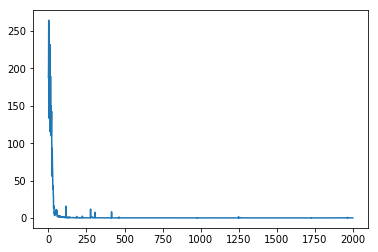

In [9]:
#Check if we can learn to count
count_cards = pd.DataFrame(dummied.groupby('card_id').count().purchase_amount)
losses = train_minibatch(count_cards, learning_rate=1E-2, num_epochs=2001)
plt.plot(losses);

Cost after epoch 0: 8.718903
Cost after epoch 100: 0.052751
Cost after epoch 200: 0.097307
Cost after epoch 300: 0.206612
Cost after epoch 400: 0.060864
Cost after epoch 500: 0.209325
Cost after epoch 600: 0.458591
Cost after epoch 700: 0.807105
Cost after epoch 800: 0.133156
Cost after epoch 900: 0.026491
Cost after epoch 1000: 3.841630
Cost after epoch 1100: 0.423557
Cost after epoch 1200: 0.209481
Cost after epoch 1300: 0.054792
Cost after epoch 1400: 0.031808
Cost after epoch 1500: 0.053614
Cost after epoch 1600: 0.024091
Cost after epoch 1700: 0.111102
Cost after epoch 1800: 0.026337
Cost after epoch 1900: 0.024871
Cost after epoch 2000: 0.155583


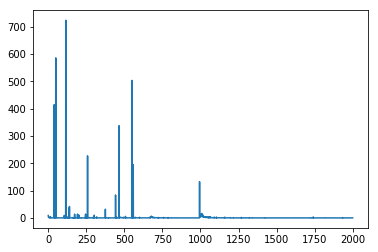

In [10]:
#Check if we can learn sum
amount_sum_cards = pd.DataFrame(dummied.groupby('card_id').agg({'purchase_amount': 'sum'}))
losses = train_minibatch(amount_sum_cards, learning_rate=1E-2, num_epochs=2001)
plt.plot(losses);